# Glosten-Milgrom Model for security market

## Deriving the model


In [1]:
%matplotlib inline
#import the needed packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import sympy as sm
import pandas as pd

#from local file import plotterwindow
from plotter import PlotterWindow

#use pretty print
sm.init_printing(use_unicode=True)

we create the equation symbols needed

In [2]:
mu_t = sm.symbols("mu_t")
mu_t1 = sm.symbols("mu_t-1")
b_t = sm.symbols("b_t")
a_t = sm.symbols("a_t")
p_t = sm.symbols("P_t")
v = sm.symbols("v")
v_h = sm.symbols("v^H")
v_l = sm.symbols("v^L")
d_t = sm.symbols("d_t")
sd_t = sm.symbols("s(d_t)")
s_a = sm.symbols("s_t^a")
s_b = sm.symbols("s_t^b")
theta_t = sm.symbols("theta_t")
theta_t1 = sm.symbols("theta_t-1")
pi = sm.symbols("pi")
beta_b = sm.symbols("beta_B")
beta_s = sm.symbols("beta_S")
spib = sm.symbols("Pi_buy")
spis = sm.symbols("Pi_sell")
theta_p=sm.symbols("theta^+")
theta_m=sm.symbols("theta^-")

There is a single market with 1 dealer. The dealer buys and sells a single security at the ask price $a_t$ and bid price $b_t$. In every time period t he takes a single order from a single trader. The order is denoted $d_t$ which takes the value 1 for buy order, -1 for a sale order and 0 for no order.

On the market there are two types of traders, Informed traders and liquidity traders. The informed traders have a high amount of information about the security and knows the true value of it. Further they seek to maximize their profit trading with the security, which leads to only buying if the security value higher than the ask price and only selling selling if the value is lower than the bid price.
Liquidity traders do not have information about the security or rather, they dont care. These traders buys or sells the security independent on the value of the security. Among liquidity traders you find traders who either seeks to diversify their portfolio, thus buy, or who needs to liquify some assets. The liquidity trader buys with probability $\beta_B$ and sells with probability $\beta_S$.

$\pi$ share of the traders is informed traders.

On the market there is unequal information. The informed traders have private information about the value of the security. The dealer only has access to public information about the market, such as the ratio of informed traders. The dealer however receives information with each trade order. An informed trader would never sell if $a_t<v$, therefore an unequal amount of buy orders would indicate $v=v^H$


Before we start on our model equations we make two assumptions:<br> i) The dealer is risk neutral and is in a competitive. <br> ii) there is no trade cost on orders on the market

To simplify our model we set the security v to be binary distributed taking the value $v^H$ or $v^L$, the superscript denoting high and low value.

The dealer has the belief $\theta_t$, which is his estimate of the probability $p(v=v^h)=\theta$. From his belief he finds his expected value of security v denoted $\mu_t$

In [17]:
sm.Eq(mu_t,theta_t*v_h+(1-theta_t)*v_l) 

The dealer sets his ask and bid price based on his expectition to v conditional on the information $\Omega_{t-1}$ and whether he expects a buy or sell order.
$$a_t=E(v\mid \Omega_{t-1} , d_t=1)$$
$$b_t=E(v\mid \Omega_{t-1} , d_t=-1)$$
Further, since the dealer is in a competitive market he sets the ask and bid price according to an expected null profit. Since the dealer does not know the true value of the security, he loses on every trade made with an informed trader. The deficit is made up by trading with liquidity traders. Based on his expectation to the security and his knowledge of the market, he derives the following profit functions

In [18]:
sm.Eq(theta_t1*pi*(a_t-v_h)+beta_b*(1-pi)*(a_t-mu_t1), sm.symbols("Pi^buy_t"))

In [19]:
sm.Eq((1-theta_t1)*pi*(v_l-b_t)+beta_s*(1-pi)*(mu_t1-b_t),sm.symbols("Pi^sell_t"))

From these profits he derives his optimal ask and bid price.

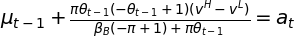

In [20]:
sm.Eq(mu_t1+(pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l), a_t)

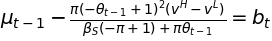

In [21]:
sm.Eq(mu_t1-(pi*(1-theta_t1)*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_s)*(v_h-v_l),b_t)

The ask and bid price equal the dealers expected value of the security with a markup and discount respectively. We denote the markup $s_t^a$ and the discount $s_t^b$

In [22]:
sm.Eq((pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l), s_a)
sm.Eq(mu_t1+s_a, a_t)

In [23]:
sm.Eq((pi*(1-theta_t1)*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_s)*(v_h-v_l), s_b)
sm.Eq(mu_t1-s_b, b_t)

Depending on the trade order the dealer receives in period t, his beliefs about the value of the security in period t+1 is changed.
$$\theta_t^{+}\equiv P(v=v^H|\Omega_{t-1},d_t=1)$$
$$\theta_t^{-}\equiv P(v=v^L|\Omega_{t-1},d_t=-1)$$

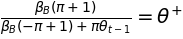

In [24]:
sm.Eq(((1+pi)*beta_b)/(pi*theta_t1+(1-pi)*beta_b),theta_p)

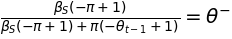

In [25]:
sm.Eq(((1-pi)*beta_s)/(pi*(1-theta_t1)+(1-pi)*beta_s),theta_m)

With his updated beliefs about the security, the dealer updates his expectation of the value of the security for the period t+1. If the dealer recieved a buy order in in period t, his expectation $\mu$ can be shown to have the following relation 
$$\mu^+_{t+1}-\mu_t=s_t^a$$
The dealers expectation for any order is therefore 
$$\mu_t=\mu_{t-1}+s(d_t)d_t$$
with $s(d_t)\equiv \begin{cases} s_t^a & d_t=1 \\ s_t^b & d_t=-1 \end{cases}$

## Simulating the model

Solving the model equilibrium is unfortunately not straight forward. The model have local equilibria for every period, which maximize the profit for informed traders and ensure null profit for the dealer. In order to find the model equibrilium, we use the algorithm below. 

**How to simulate the Glosten-Milgrom model**
1. choose start values and parameters. Set threshold value $\epsilon$
2. calculate value expectation, then ask/bid price.
3. determine trader type, then order type
4. update dealer beliefs
5. repeat step 2-4 until $\epsilon > spread = a_t - b_t$

The flow chart below shows more detailed steps to simulate our model. We followed the flow of the chart to create the function simulation()

![Flowchart](flowchart.png)

In the code below we define the function simulation, which simulates our model in accordance with flow chart above. 

In [26]:
def simulation(distribution=(0,1), decision="v_h", ratio=0.2, uninformed=0.5, startvalue=0.5, iterations = 500, seed=5000, epsilon=10**-5, shockperiod = None, shock={}):
    #define constants
    v_l, v_h = distribution
    pi = ratio
    beta_b = uninformed
    beta_s = 1-beta_b
    shock = shock
    
    #determine realized value of v
    v = decision
    
    #allocate space
    values={}
    ratiovalues = []
    iteration = []
    thetavalues = np.empty(iterations)
    muvalues = np.empty(iterations)
    askvalues = np.empty(iterations)
    bidvalues = np.empty(iterations)
    gapvalues = np.empty(iterations)
    pivalues = np.empty(iterations)
    decisionvalues = np.empty(iterations)
    
    #simulation settings
    thetavalues[0]=startvalue
    theta_t1 = startvalue
    N = iterations
    np.random.seed(seed)
    
    break_index = 0
    for i in range(N):
        
        if i==shockperiod:
            if shock != {}:
                if "Public" not in shock:
                    if shock["Private"]==1:
                        v="v_h"
                    if shock["Private"]==0:
                        v="v_l"

                elif "Private" not in shock:
                    v_l, v_h = shock["Public"] 
                    v = decision
                
                else:
                    v_l, v_h = shock["Public"]
                    if shock["Private"]==1:
                        v="v_h"
                    if shock["Private"]==0:
                        v="v_l"
                    
        if v=="v_h":
            v=v_h
        elif v=="v_l":
            v=v_l
            
        
        mu_t1 = theta_t1*v_h+(1-theta_t1)*v_l
        muvalues[i] = mu_t1
        
        #calculate markup/discount
        s_a = (pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l)
        s_b = (pi*theta_t1*(1-theta_t1))/(pi*(1-theta_t1)+(1-pi)*beta_s)*(v_h-v_l)
        
        #calculate ask/bid price
        askvalues[i] = a_t = mu_t1 + s_a
        bidvalues[i] = b_t = mu_t1 - s_b 
        
        #calculate gap
        gapvalues[i] = gap_t = a_t - b_t
        
        #realize pi
        trader = np.random.binomial(1,pi)
        pivalues[i] = trader
        #if trader is informed
        if trader == 1:
            if v == v_h:
                if v_h>a_t:
                    d_t=1
            elif v == v_l:
                if v_l<b_t:
                    d_t=-1
            else:
                d_t=0
                    
        #if trader is uninformed
        if trader == 0:
            buysell = np.random.binomial(1,beta_b)
            if buysell == 1:
                d_t = 1
            else:
                d_t = -1
        
        decisionvalues[i] = d_t
        
        #update theta
        if d_t == 1:
            theta_t = ((1+pi)*beta_b)/(pi*theta_t1+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        elif d_t == -1:
            theta_t = ((1-pi)*beta_b)/(pi*(1-theta_t1)+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        
        if i<iterations-1:
            thetavalues[i+1] = theta_t
        ratiovalues.append(str(ratio))
        iteration.append(int(i))
        
        #off by one error
        break_index=i+1
        if gap_t<epsilon or i == N-1:
            values.update({"Theta": theta_t,"Bid": b_t, "Ask": (a_t), "Mu": mu_t1, "Equilibrium period": break_index-1})
            break
            
    
    dataframe = pd.DataFrame()
    dataframe["Iteration"] = iteration
    dataframe["ratio"] = ratiovalues
    dataframe["theta"] = thetavalues[0:break_index]
    dataframe["mu"] = muvalues[0:break_index]
    dataframe["ask"] = askvalues[0:break_index]
    dataframe["bid"] = bidvalues[0:break_index]
    dataframe["spread"] = gapvalues[0:break_index]
    dataframe["trader"] = pivalues[0:break_index]
    dataframe["order"] = decisionvalues[0:break_index]
    
    return dataframe, values

The simulation function depends on several random distributions in order to simulate our models. Thus, running a single instance of the function will not create credible results. In order to get credible values for our equilibrium we create the function numericalsolution, which loops the simulation function N times with random seeds. The output is the mean values for the N different equilibria.

In [104]:
def numericalsolution(N=1000, ratio=0.15):
    data = pd.DataFrame()
    
    for i in range(N):
        seed = int(np.random.uniform(0,10000))
        dataframe, values = simulation(distribution=(0,10), ratio=ratio, startvalue=0.5, iterations = 1001, seed=seed, epsilon=5**-5)
        
        for key in values:
            data.loc[i,key]=values[key]
            
    meanvalues = {}
    for key in list(data.columns):
        meanvalues[key]=data[key].mean()
    return meanvalues

In [105]:
numericalsolution()

{'Theta': 0.9999522089136563,
 'Bid': 9.99937042512405,
 'Ask': 9.999656044732731,
 'Mu': 9.999534654405569,
 'Equilibrium period': 216.922}

with a ratio 0.15 we reach equilibrium after 216 iterations on average. As expected $\theta_t$ converges towards 1, while ask price, bid price and expected value converges towards the true value of the security.

In order to examine the influence of the ratio of traders, we construct a for loop to run numericalsolution with $\pi \in [0.01;1]$.

The code below is quite taxing to run, so we have included a line to prevent you from running it. We have included a data file in our repository containing the data from running the code below, which we use to make the following graph. You can run the code by commenting out import nothing.py.

In [ ]:
#To prevent you from accidently running it we have include the line below.
import nothing.py

#make lists
ratiolist = []
periodlist = []

#loop the function numericalsolution
for i in range(99):
    num = ((i+1)/100)
    values = numericalsolution(ratio=num)
    
    ratiolist.append(num)
    periodlist.append(values["Equilibrium period"])


Text(0, 0.5, 'Period')

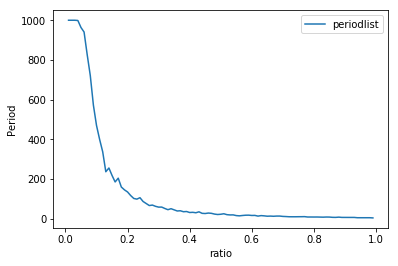

In [102]:
#if you ran the above code, uncomment the three lines below to graph the data
#plt.plot(ratiolist,periodlist)
#plt.xlabel("ratio")
#plt.ylabel("Period")

#alternative:
#read data file
doomloopdata = pd.read_csv("./doomloopdata.csv")
doomloopdata.columns = ["periodlist","ratiolist"]

#plot the data
doomloopdata.plot("ratiolist","periodlist")
plt.xlabel("ratio")
plt.ylabel("Period")

The speed of convergence towards the equilibrium is heavily determined by the ratio of informed traders. In our model the dealer gets information about the true value of the security from the trade flow. With more informed traders on the market the amount of information in the trade flow is higher.

## Aspects of the model

#### Seed
In our simulation function we rely on random distributions to simulate our model. This short chapter will demonstrate the randomness of a single iteration of the simulation function. We call our function with alternating seeds but all other settings equal.

Text(0.5, 1.0, 'Theta')

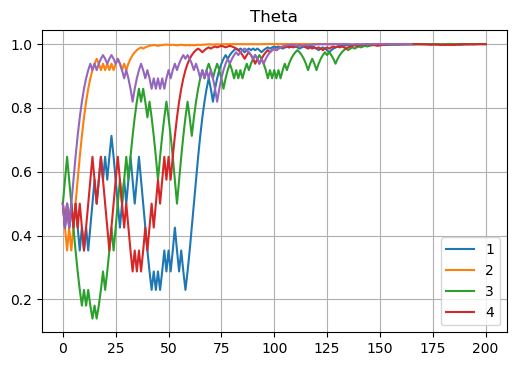

In [88]:
#calling simulation function
thetarun1 = simulation(ratio=0.15, iterations=201,seed=4795)
thetarun2 = simulation(ratio=0.15, iterations=201,seed=6279)
thetarun3 = simulation(ratio=0.15, iterations=201,seed=6130)
thetarun4 = simulation(ratio=0.15, iterations=201,seed=9352)
thetarun5 = simulation(ratio=0.15, iterations=201,seed=5059)

#saving return data
thetadata1, thetavalues1 = thetarun1
thetadata2, thetavalues2 = thetarun2
thetadata3, thetavalues3 = thetarun3
thetadata4, thetavalues4 = thetarun4
thetadata5, thetavalues5 = thetarun5

fig = plt.figure(dpi=100)
ax2 = fig.add_subplot(1,1,1)
ax2.plot(thetadata1["theta"], label="1")
ax2.plot(thetadata2["theta"], label="2")
ax2.plot(thetadata3["theta"], label="3")
ax2.plot(thetadata4["theta"], label="4")
ax2.plot(thetadata5["theta"], label="")
ax2.grid(True)
ax2.legend()
ax2.set_title("Theta")

As we can see in the graph above, all the simulations converges towards equilibrium. The speed of convergence however is vastly different for the different seeds.

#### ratio of informed traders

We call the simulation for different values of $\pi$ and plot bid price, ask price and expected value $\mu_t$ in our custom interactive graphwindow class. In the graph window you are able move around in the plot and examine the development of the model for different $\pi$ values

In [10]:
#call simulation function 5 times with different ratios
pirun1 = simulation(ratio=0.10, iterations=1001, seed=404)
pirun2 = simulation(ratio=0.15, iterations=1001, seed=404)
pirun3 = simulation(ratio=0.25, iterations=1001, seed=404)
pirun4 = simulation(ratio=0.5, iterations=201, seed=404)
pirun5 = simulation(ratio=0.9, iterations=201, seed=404)

#save data
pirundata1, pirunvalues1 = pirun1
pirundata2, pirunvalues2 = pirun2
pirundata3, pirunvalues3 = pirun3 
pirundata4, pirunvalues4 = pirun4
pirundata5, pirunvalues5 = pirun5

#merge data
pirunmerged = pd.concat([pirundata1, pirundata2, pirundata3, pirundata4, pirundata5])

#call custom graphwindow class with graphtype=piplot
pirungraphwindow = PlotterWindow(data = pirunmerged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], graphtype ="piplot")
pirungraphwindow.start()

The code below opens another instance of our graphwindow. The plots are candlestick plots, which maps the difference in ask and bid price.

In [11]:
#call custom graphwindow class with graphtype=candlestick
pirungraphwindow2 = PlotterWindow(data = pirunmerged, slicename = "ratio", graphtype = "candlestick")
pirungraphwindow2.start()

C:\Users\Corfixen\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


As seen in both the piplot and candlestick graphwindow, the initial spread between ask and bid prices heavily depend on the ratio $\pi$. Higher values of $\pi$ leads to higher initial spread. The dealer have to compensate his prices for the higher amount of orders from informed traders to ensure the null profit

## Shocks to the model

Simply simulating the model is not as interesting. In this chapter we introduce several types of shocks to the market and graph the result. We would have preferred to run this chapter with a modified numericalsolution function to get better results. We settled on the simulation function due to the lower amount of computational power needed. As such the results are not as credible as they could be.

We simulate our model with three different types of shocks. 
1. The first shock is a shock in private information. We change the realisation of the variable v, which only the informed traders know the true value of. A real-life example of this type of shock would be a trader recieving insider info from a firm. 
2. The second shock is a public information shock. We change the upper and lower value for v. This information is available to all on the market. A real-life example of this type of shock would be the release of the annual report from a firm
3. We shock the model with both private and public information.

all of the shocks incur in the 90th period. To avoid naming conflict in our graphwindow we set a slighty different ratio for the different calls. The difference on the results are negligible 

In [108]:
#call simulation function with different shock types
shockrun1 = simulation(ratio=0.15001, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0})
shockrun2 = simulation(ratio=0.15002, iterations=1001, seed=404, shockperiod = 90, shock={"Public":(0.3, 0.8)})
shockrun3 = simulation(ratio=0.15003, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0, "Public":(0.3,0.8)})

#save results
shockdata1, shockvalues1 = shockrun1
shockdata2, shockvalues2 = shockrun2
shockdata3, shockvalues3 = shockrun3

#merge results
shockmerged = pd.concat([shockdata1,shockdata2,shockdata3])

#call custom graphwindow class with graphtype = piplot
shockgraphwindow = PlotterWindow(data = shockmerged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], graphtype="piplot")
shockgraphwindow.start()

all graph converges towards the same equilibrium before the shock.
1. After the shock the model slowly converges towards the new equilibrium, which is at $a_t, b_t, \mu_t \rightarrow v^L$. The dealer slowly receives information about the new equilibrium from the informed traders behavior. He adjusts his ask and bid price to make up for the new informed trader strategy.
2. The change in the prices happens instantly when the new information is made available. This behavior on the market suggests our model is semi-strong form efficient, since the market instantly adepts to the new public information.
3. With both shock types we see the instant respons to the public information. The reaction to the private information shock is rather slow, as with the first graph.


# Conclusion

In this paper we found the Gloston-milgrom model capable of adapting to public and private information. The model simulated the behavior of several types of traders and a market maker (the dealer), and showed their adaptions to the information avaliable. The model further shows this adaptation of information by the equilibrium prices converging on the true value of the security <br>
The ratio of informed traders $\pi$ on the market have a huge impact on the speed of convergence and spread of ask and bid prices.<br>
From the shocks we introduce to the model we conclude the model is semi-strong form efficient. 